# SIT744 Practical 11: LSTM


*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>


## Pre-practical readings

- [Understanding recurrent neural networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/6.2-understanding-recurrent-neural-networks.ipynb)

This is a short practical showing how to use LSTM layer to process text data.


## Task 1 Use an LSTM layer

Let's continue with last week's imdb dataset. Again, we download both the integer coded sequences and the dictionary.

In [ ]:
from tensorflow.keras.datasets import imdb

# Number of words to consider as features
max_features = 10000

word_index = imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items() if id_ <= max_features} # Offset by 3

## Special padding tokens; "<pad>" does not actually exist in the data we retrieved
for id_, token in enumerate(("<sos>", "<unk>", "<pad>")):
  id_to_word[id_+1] = token

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


17465344/17464789 [==============================] - 0s 0us/step


Let's look at the distribution of the sequence length.

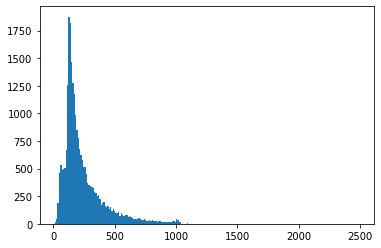

In [ ]:
import matplotlib.pyplot as plt

seq_length = [len(s) for s in x_train]
n, bins, patches = plt.hist(x=seq_length, bins='auto')

Although LSTM is good at looking for global patterns in long sequences, the training will become too slow when the input sequences are long. From the histogram above, it seems that we can truncate or pad all sequences to 500. We will need sequences to have the same length in a batch anyway.

In [ ]:
from tensorflow.keras import preprocessing

maxlen = 500

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

As we saw last week, we need to first embed each integer code into a dense vector.

In [ ]:
import tensorflow as tf
from  tensorflow import keras
import numpy as np


embedding_dim = 100

embedding_layer = keras.layers.Embedding(max_features, embedding_dim)


From the embedding layer, we get a 2D tensor that can be fed into an LSTM layer.

In [ ]:
def  make_model():
  model = keras.models.Sequential()
  model.add(embedding_layer)
  model.add(keras.layers.LSTM(32, return_sequences=True))
  model.add(keras.layers.LSTM(32))
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          17024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,025,377
Trainable params: 1,025,377
Non-trainable params: 0
_________________________________________________________________


**question** What activation functions were used in the LSTM layer?


The training of the model is no different from training  other Keras models.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 12s 74ms/step - loss: 0.4384 - acc: 0.7994 - val_loss: 0.6088 - val_acc: 0.7434
Epoch 2/10
157/157 [==============================] - 11s 68ms/step - loss: 0.2735 - acc: 0.8939 - val_loss: 0.2889 - val_acc: 0.8854
Epoch 3/10
157/157 [==============================] - 11s 69ms/step - loss: 0.2219 - acc: 0.9180 - val_loss: 0.3139 - val_acc: 0.8714
Epoch 4/10
157/157 [==============================] - 11s 69ms/step - loss: 0.1823 - acc: 0.9348 - val_loss: 0.3160 - val_acc: 0.8822
Epoch 5/10
157/157 [==============================] - 11s 69ms/step - loss: 0.1581 - acc: 0.9421 - val_loss: 0.3011 - val_acc: 0.8786
Epoch 6/10
157/157 [==============================] - 11s 69ms/step - loss: 0.1317 - acc: 0.9532 - val_loss: 0.3524 - val_acc: 0.8766
Epoch 7/10
157/157 [==============================] - 11s 69ms/step - loss: 0.1092 - acc: 0.9616 - val_loss: 0.4241 - val_acc: 0.8474
Epoch 8/10
157/157 [==============================] - 11s 68ms

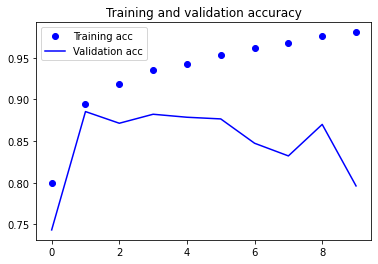

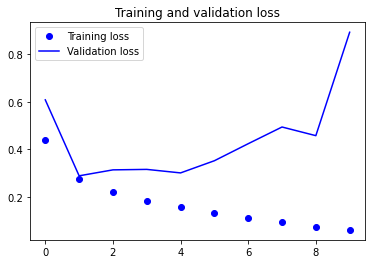

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As we can see, overfitting happens.


## Task 2 Use pretrained word embedding

We will use the Glove words embedding. Most pretrained word embeddings are quite big; It will take a while to download the file.


In [ ]:
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/wordvecs/glove.6B.zip \
    -O /tmp/glove.6B.zip

import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


local_zip = '/tmp/glove.6B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-05-24 00:23:45--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2020-05-24 00:23:46--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2020-05-24 00:23:46--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [applic

The zip file contains multiple embeddings of different dimensionalities. We will use the one with 100 dimensions.

In [ ]:
glove_dir = '/tmp/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


We do not need all these embeddings as we have only 10000 words.

In [ ]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for id_ in range(1, 10000):
  word = id_to_word[id_]
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      embedding_matrix[id_] = embedding_vector

Now you can swap the random embedding with this pretrained embedding.

In [ ]:
embedding_layer.set_weights([embedding_matrix])

We can continue the training, although it may be better to reinitialise the weights as the embedding has completely changed.



In [ ]:
model = make_model()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 11s 73ms/step - loss: 0.5862 - acc: 0.6771 - val_loss: 0.5985 - val_acc: 0.6900
Epoch 2/10
157/157 [==============================] - 11s 68ms/step - loss: 0.4361 - acc: 0.8049 - val_loss: 0.4167 - val_acc: 0.8226
Epoch 3/10
157/157 [==============================] - 11s 68ms/step - loss: 0.3589 - acc: 0.8484 - val_loss: 0.3478 - val_acc: 0.8508
Epoch 4/10
157/157 [==============================] - 11s 68ms/step - loss: 0.3020 - acc: 0.8768 - val_loss: 0.3170 - val_acc: 0.8696
Epoch 5/10
157/157 [==============================] - 11s 69ms/step - loss: 0.2486 - acc: 0.9012 - val_loss: 0.4305 - val_acc: 0.8136
Epoch 6/10
157/157 [==============================] - 11s 68ms/step - loss: 0.2194 - acc: 0.9165 - val_loss: 0.2832 - val_acc: 0.8920
Epoch 7/10
157/157 [==============================] - 11s 68ms/step - loss: 0.1933 - acc: 0.9270 - val_loss: 0.3021 - val_acc: 0.8870
Epoch 8/10
157/157 [==============================] - 11s 68ms

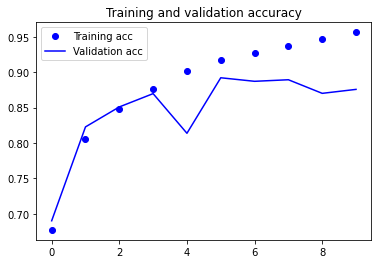

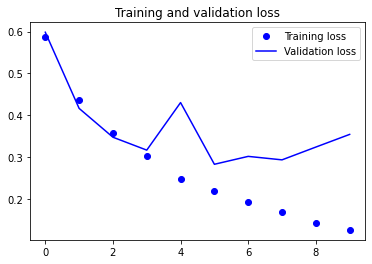

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation accuracy improved. But we can still add some regularisation to control overfitting.

In [ ]:
def  make_model():
  model = keras.models.Sequential()
  model.add(embedding_layer)
  model.add(keras.layers.LSTM(32, recurrent_dropout=0.2))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  return model

model = make_model()
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 300s 2s/step - loss: 0.4664 - acc: 0.7835 - val_loss: 0.3973 - val_acc: 0.8320
Epoch 2/10
157/157 [==============================] - 301s 2s/step - loss: 0.3317 - acc: 0.8669 - val_loss: 0

As you can see, the training is much slower with the added recurrence dropout.

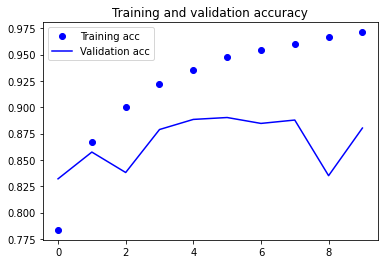

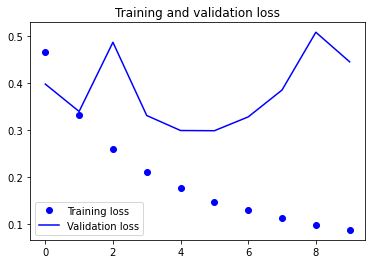

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**question** How did the addition of recurrent dropout affect the training speed? Measure the difference in training time.

**exercise** Try to use a bidirectional LSTM and see if the validation accuracy improves. Then try two layers of bidirectional LSTM.

## Additional resources

- [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn)